# Data exploration

This notebook will explore the images we have and extract data from them. The images have 4 channels (DAPI, EdU, and two Alexa's, one being PCNA). The data we extract from the channels are the pixel intensities.

Pipeline (Pseudo-code) to gather training data:

Upload from Omero all images from a well
For each image
- make a prediction for the cells
- make the crops around the cells in each channel
- make a dataframe with the first row being the one for the Alexa555 (PCNA) image crops
- get the pixel intensity of the crops in each channel and add it to the dataframe where each column corresponds to a channel's intentisity for that crop
- normalise that pixel intensity data per channel

Stack all the dataframes together
Get the DNA value data from the DAPI channel (Helfrid's function) and add it to the dataframe
Get the background value of the Cyclin A2 and EdU channels
Apply the G1, S and G2/M rules where they are each a column in the dataframe with True if the cell's data follows the rule to be in that phase and False if not
Plot that cell cycle phase channel data in a 4D graph where each axis is data from a channel
Plot some cells from each classification cropped in the Alexa555 channel

## Importing data

Note: since I'm working from home right now, I'm struggling with my connection to Omero so I'm importing data I saved from earlier. When I'm back in the lab I will change this part to be importing data from Omero with the plate number.

In [30]:
#Get all images from Omero
import ezomero
import numpy as np

#Step 1: Connect to Omero

HOST = 'ome2.hpc.sussex.ac.uk' #change if different
port=4064
conn = ezomero.connect(user='rz200',password='omeroreset',group='',host=HOST,port=4064,secure=True)
if conn: print('Connection successful')
else: print('Unsuccessful')

#Step 2: Load the images
plate = 822
image_ids = ezomero.get_image_ids(conn,plate=plate)
print('In plate',plate,'we have',len(image_ids),'images')

model_dir = "C:\\Users\\rz200\\Documents\\Development\\cell-SCT\\segmentation\\demo_train_test_data\\data_for_masks_training\\models\\demo_model"

#Make a loop that goes through each image and store them in a numpy array or even in the dataframe
 #this gets the first image, it has 4 channels
#ori_img = np.reshape(image[1],(1080,1080,4)) #full_image with 4 channels
#dapi_img = np.reshape(image[1],(1080,1080,4))[:,:,0] #channel 0 is Hoechst 33342, very similar to DAPI
#edu_img = np.reshape(image[1],(1080,1080,4))[:,:,1] #channel 1 is Cy5 aka EdU
#cyclina2_img = np.reshape(image[1],(1080,1080,4))[:,:,2] #channel 2 is Alexa488 aka Cyclin A2
#pcna_img = np.reshape(image[1],(1080,1080,4))[:,:,3] #channel 3 is Alexa555 aka PCNA

Connection successful
In plate 822 we have 1500 images


In [10]:
import time
start = time.time()

plate_images = []
for i in range(len(image_ids[:50])):
    plate_images.append(ezomero.get_image(conn,image_id=image_ids[i]))
plate_images = np.array(plate_images)
#At some point I want to get all the 1500 images, put them in the dataframe and export as a CSV to save as training data

end = time.time()
print(end - start)

44.608195543289185


C:\Users\rz200\AppData\Local\Temp\ipykernel_23632\288618434.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plate_images = np.array(plate_images)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
524.3912267684937


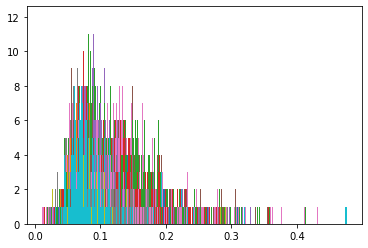

In [11]:
import sys, importlib
importlib.reload(sys.modules['classification.ccc_functions'])
from classification.ccc_functions import build_mega_cell_df

import time
start = time.time()

model_dir = "C:\\Users\\rz200\\Documents\\Development\\cell-SCT\\segmentation\\demo_train_test_data\\data_for_masks_training\\models\\demo_model"
df_mega = build_mega_cell_df(plate_images,model_dir)

end = time.time()
print(end - start)

In [57]:
#Save dataframe to csv

from pathlib import Path
filepath = Path('C:\\Users\\rz200\\Documents\\Development\\cell-SCT\\classification\\training_data\\td_first50.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_mega.to_csv(filepath) #should make this a function and also make a function to read the csv
#and also add the loading bars

In [16]:
import sys, importlib
importlib.reload(sys.modules['classification.ccc_functions'])
from classification.ccc_functions import count_phases
count_phases(df_mega)

Total cells: 10838
S phase: 39.8%
G1 phase: 44.81%
G2/M phase: 11.4%


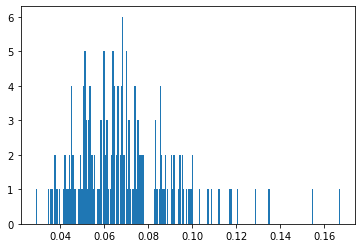

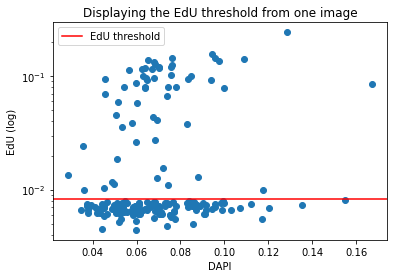

In [28]:
#Should show the EdU and CyclinA2 threshold to display here
#Also to send to Helfrid

from classification.ccc_functions import build_one_cell_df,get_EdU_threshold
import matplotlib.pyplot as plt

#Get a dataframe for the first image
df_one = build_one_cell_df(plate_images[0],model_dir)

#Get the EdU threshold for it
edu_threshold = get_EdU_threshold(df_one, 'edu_values')

#Display the EdU vs DAPI plot
edu_values = df_one['edu_values'].values
dapi_values = df_one['dapi_values'].values
plt.title('Displaying the EdU threshold from one image')
plt.plot(dapi_values,edu_values,'o')
plt.yscale('log')
plt.xlabel('DAPI')
plt.ylabel('EdU (log)')
plt.axhline(y=edu_threshold, color='r', linestyle='-',label='EdU threshold')
plt.legend()
plt.savefig('EdUthresh.png')
plt.show()

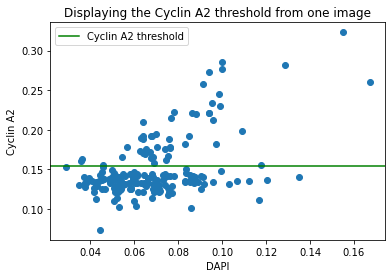

In [29]:
#Get the Cyclin A2 threshold for it
cyclina2_threshold = get_EdU_threshold(df_one, 'cyclina2_values')

#Display the EdU vs DAPI plot
cyclina2_values = df_one['cyclina2_values'].values
dapi_values = df_one['dapi_values'].values
plt.title('Displaying the Cyclin A2 threshold from one image')
plt.plot(dapi_values,cyclina2_values,'o')
#plt.yscale('log')
plt.xlabel('DAPI')
plt.ylabel('Cyclin A2')
plt.axhline(y=cyclina2_threshold, color='g', linestyle='-',label='Cyclin A2 threshold')
plt.legend()
plt.savefig('CyclinA2thresh.png')
plt.show()

In [55]:
def get_training_data(df):

    pcna_images = df['pcna_crops'].values

    cycle_phase_encodings = []
    for i in range(len(df['S_Phase'])):
        encoding_arr = []
        if df['G1_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        if df['S_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        if df['G2_M_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        cycle_phase_encodings.append(encoding_arr)

    training_data = []
    for j in range(len(pcna_images)):
        training_data.append((pcna_images[j],cycle_phase_encodings[j]))

    training_data = np.array(training_data,dtype=object)

    return training_data

In [64]:
training_data = get_training_data(df_mega)
print(training_data.shape)

(10838, 2)


In [91]:
#We need to build a training folder and a test folder
#This should eventually become a function
#The folder needs to resemble the following structure:
#pcna_train
# #s_phase
# # #image1
# # #image2
# # #...
# #g1_phase
# # #image1
# # #image2
# # #...
# #g2_m_phase
# # #image1
# # #image2
# # #...

#And then the same structure but for the test folder

#tutorial we're following now for the CNN:https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

In [83]:
import cv2

train_img = training_data[:,0]
train_img_padded = []

for i in range(len(train_img)):
    train_img_padded.append(cv2.copyMakeBorder(train_img[i], 100-train_img[i].shape[0], 0, 100-train_img[i].shape[1], 0, cv2.BORDER_CONSTANT))

train_y = []
print('train data shape',training_data[:,1].shape)
for encoding in training_data[:,1]:
    if encoding == [1,0,0]:
        train_y.append(0)
    elif encoding == [0,1,0]:
        train_y.append(1)
    elif encoding == [0,0,1]:
        train_y.append(2)

train_x = []
for i in range(len(train_img_padded)):
    if training_data[:,1][i] != [0,0,0]:
        train_x.append(train_img_padded[i])

train_y = np.array(train_y)
print('train_y shape',train_y.shape)
train_x = np.array(train_x)
print('train_x shape',train_x.shape)

train data shape (10838,)
train_y shape (10405,)
train_x shape (10405, 100, 100)


In [84]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(train_x) - val_size

train_data,val_data = random_split(train_x,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 8405
Length of Validation Data : 2000


In [90]:
print(train_dl)

In [86]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

ValueError: too many values to unpack (expected 2)

In [33]:
#Let's plot some cells of each phase here, I want the 4 channels each time

#Plotting S_phase cells
is_S = df['S_Phase']==True
count = 0
i = 0
num_cells = 5
plt.figure(figsize=(12,12))
while count < num_cells*4:
    if is_S[i]:

        plt.subplot(5,4,count+1)
        if count == 0: plt.title('DAPI')
        plt.imshow(df['dapi_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+2)
        if count == 0: plt.title('EdU')
        plt.imshow(df['edu_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+3)
        if count == 0: plt.title('Cyclin A2')
        plt.imshow(df['cyclina2_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+4)
        if count == 0: plt.title('PCNA')
        plt.imshow(df['pcna_crops'][i],vmin=0,vmax=1);plt.axis('off')

        count += 4
        i+=1
    else:i+=1
print('S phase cells in 4 channels')
plt.show()

NameError: name 'df' is not defined

In [ ]:
#Plotting G1_phase cells
is_G1 = df['G1_Phase']==True
count = 0
i = 0
num_cells = 5
plt.figure(figsize=(12,12))
while count < num_cells*4:
    if is_G1[i]:

        plt.subplot(5,4,count+1)
        if count == 0: plt.title('DAPI')
        plt.imshow(df['dapi_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+2)
        if count == 0: plt.title('EdU')
        plt.imshow(df['edu_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+3)
        if count == 0: plt.title('Cyclin A2')
        plt.imshow(df['cyclina2_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+4)
        if count == 0: plt.title('PCNA')
        plt.imshow(df['pcna_crops'][i],vmin=0,vmax=1);plt.axis('off')

        count += 4
        i+=1
    else:i+=1
print('G1 phase cells in 4 channels')
plt.show()

In [ ]:
#Plotting G2_M_phase cells
is_G2_M = df['G2_M_Phase']==True
count = 0
i = 0
num_cells = 5
plt.figure(figsize=(12,12))
while count < num_cells*4:
    if is_G2_M[i]:

        plt.subplot(5,4,count+1)
        if count == 0: plt.title('DAPI')
        plt.imshow(df['dapi_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+2)
        if count == 0: plt.title('EdU')
        plt.imshow(df['edu_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+3)
        if count == 0: plt.title('Cyclin A2')
        plt.imshow(df['cyclina2_crops'][i],vmin=0,vmax=1);plt.axis('off')

        plt.subplot(5,4,count+4)
        if count == 0: plt.title('PCNA')
        plt.imshow(df['pcna_crops'][i],vmin=0,vmax=1);plt.axis('off')

        count += 4
        i+=1
    else:i+=1
print('G2/M phase cells in 4 channels')
plt.show()

In [ ]:
#Plotting a 4D axis from each channel's value

In [ ]:
#Function to take a dataframe and extract the PCNA images with their label in one hot encoding

def get_training_data(df):

    pcna_images = df['pcna_crops'].values

    cycle_phase_encodings = []
    for i in range(len(df['S_Phase'])):
        encoding_arr = []
        if df['G1_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        if df['S_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        if df['G2_M_Phase'][i]: encoding_arr.append(1)
        else: encoding_arr.append(0)

        cycle_phase_encodings.append(encoding_arr)

    training_data = []
    for j in range(len(pcna_images)):
        training_data.append((pcna_images[j],cycle_phase_encodings[j]))

    training_data = np.array(training_data,dtype=object)

    return training_data

In [ ]:
training_data = get_training_data(df)

In [ ]:
print(training_data[:,0])

In [67]:
from torch.nn import Dropout2d
import cv2
#Let's train a small CNN on the training data we have to see how it does
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F

train = training_data
#test = pd.read_csv('test_ScVgIM0/test.csv')

#sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

train_img = training_data[:,0]
train_img_padded = []

for i in range(len(train_img)):
    train_img_padded.append(cv2.copyMakeBorder(train_img[i], 60-train_img[i].shape[0], 0, 60-train_img[i].shape[1], 0, cv2.BORDER_CONSTANT))

train_y = []
print('train data shape',training_data[:,1].shape)
for encoding in training_data[:,1]:
    if encoding == [1,0,0]:
        train_y.append(0)
    elif encoding == [0,1,0]:
        train_y.append(1)
    elif encoding == [0,0,1]:
        train_y.append(2)

train_x = []
for i in range(len(train_img_padded)):
    if training_data[:,1][i] != [0,0,0]:
        train_x.append(train_img_padded[i])

train_y = np.array(train_y)
print('train_y shape',train_y.shape)
train_x = np.array(train_x)
print('train_x shape',train_x.shape)

def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows
    nC0 = len(im[0])  # source number of columns
    return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]
              for c in range(nC)] for r in range(nR)]

train_x_resized = []
for image in train_x:
    train_x_resized.append(scale(image,28,28))
train_x_resized = np.array(train_x_resized)

train_x, val_x, train_y, val_y = train_test_split(train_x_resized, train_y, test_size = 0.1)
train_x = np.array(train_x)
val_x = np.array(val_x)
val_y = np.array(val_y)
#(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)
print((train_x.shape, train_y.shape), (val_x.shape, val_y.shape))


# converting training images into torch format
train_x = train_x.reshape(161, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(float);
train_y = torch.from_numpy(train_y)

# converting validation images into torch format
val_x = val_x.reshape(18, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(float);
val_y = torch.from_numpy(val_y)

class Net(Module):
    def __init__(self):
        super(Net, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = Conv2d(1, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = Dropout2d(0.25)
        self.dropout2 = Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = Linear(128, 1)

    # Defining the forward pass
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\copy.cpp:1026: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'cv::copyMakeBorder'


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    print(x_train.shape)
    print(y_train.shape)

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # prediction for training and validation set
    x_train = x_train.float()
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    y_train = y_train.float()
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

In [ ]:
random_data = torch.rand((6, 1, 28, 28))
print(random_data.shape)

my_nn = Net()
result = my_nn(random_data)
print (result)

In [ ]:
#Put all the data together for a quantitative investigation

#Step 1: Stack all the dataframes together

#Step 2: Plot that cell cycle phase channel data in a 4D graph where each axis is data from a channel

#Step 3: Plot some cells from each classification cropped in the Alexa555 channel

#Step 4: A Venn diagram of the cell phases with their True or False, we'll see some applying to the same rules

In [ ]:
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

g1_values = np.asarray(df['G1_Phase'],dtype=bool)
s_values = np.asarray(df['S_Phase'],dtype=bool)
g2_m_values = np.asarray(df['G2_M_Phase'],dtype=bool)

only_s = sum(~g1_values & s_values & ~g2_m_values)
only_g1 = sum(g1_values & ~s_values & ~g2_m_values)
only_g2_m = sum(~g1_values & ~s_values & g2_m_values)
g1_and_s = sum(g1_values & s_values & ~g2_m_values)
g1_and_g2_m = sum(g1_values & ~s_values & g2_m_values)
s_and_g2_m = sum(~g1_values & s_values & g2_m_values)
g1_and_s_and_g2_m = sum(g1_values & s_values & g2_m_values)
no_label = sum(~g1_values & ~s_values & ~g2_m_values)

#print(only_g1,only_s,only_g2_m,g1_and_s,g1_and_g2_m,s_and_g2_m,g1_and_s_and_g2_m)
print('Number of cells only in S phase:',only_s)
print('Number of cells only in G1 phase:',only_g1)
print('Number of cells only in G2/M phase:',only_g2_m)
print('Number of cells only in S and G1 phase:',g1_and_s)
print('Number of cells only in S and G2/M phase:',s_and_g2_m)
print('Number of cells only in G1 and G2/M phase:',g1_and_g2_m)
print('Number of cells labelled (G1, S and G2/M):',g1_and_s_and_g2_m)
print('Number of cells not labelled:',no_label)

#venn3(subsets = (only_g1, only_s, g1_and_s, only_g2_m, g1_and_g2_m, s_and_g2_m, g1_and_s_and_g2_m), set_labels = ('G1', 'S', 'G2/M'))
plt.figure(figsize=(6,6))
v = venn3_unweighted(subsets = (only_g1, only_s, g1_and_s, only_g2_m, g1_and_g2_m, s_and_g2_m, g1_and_s_and_g2_m),
                     set_labels = ('G1', 'S', 'G2/M'))
#c = venn3_circles(subsets = (only_g1, only_s, g1_and_s, only_g2_m, g1_and_g2_m, s_and_g2_m, g1_and_s_and_g2_m),linestyle='dashed')

In [ ]:
#TODELETE: Here we were importing images from a directory but now we'll do with Omero
#Here we get the images from a directory in the project, normalise and display them

import numpy as np
import matplotlib.pyplot as plt

#Loading the images
gray_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/gray_img.npy')
dapi_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/dapi_img.npy')
edu_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.npy')

#Normalising the images
def normalise_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

gray_img = normalise_img(gray_img)
dapi_img = normalise_img(dapi_img)
edu_img = normalise_img(edu_img)

#Displaying the images
plt.figure(figsize=(12,12))
plt.subplot(1,3,1);plt.imshow(gray_img);plt.axis('off');plt.title('Gray')
plt.subplot(1,3,2);plt.imshow(dapi_img);plt.axis('off');plt.title('DAPI')
plt.subplot(1,3,3);plt.imshow(edu_img);plt.axis('off');plt.title('EdU');plt.show()

In [ ]:
#Make a segmentation prediction, right now with the Gray image as that's all we have, later with the Alexa555 (PCNA) image

from cellpose import models
model_dir = "/Users/rehanzuberi/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
model = models.CellposeModel(gpu=True, pretrained_model=model_dir)
test_data = [gray_img]
predicted_test_masks = model.eval(test_data, channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions # we could use the fact that it has a channel input to have the normal image not separated by channel and just make it do the prediction on there, although we need it to make a prediction on the averaged out gray image so that wouldn't really work
predicted_mask = predicted_test_masks[0]

In [ ]:
#Now we get the crops from each channel and store them in a numpy array
import segmentation.seg_functions
from importlib import reload
from segmentation.seg_functions import count_cells, get_cell_crop_coordinates, get_img_crops
segmentation.seg_functions = reload(segmentation.seg_functions)

print('Prediction has', count_cells(predicted_mask), 'cells')
crop_coordinates = get_cell_crop_coordinates(predicted_mask, margin=3)
gray_crops = get_img_crops(gray_img, crop_coordinates)
dapi_crops = get_img_crops(dapi_img, crop_coordinates)
edu_crops = get_img_crops(edu_img, crop_coordinates)

#We could have one numpy array called 'cells' that holds the images and later on the values

In [ ]:
mines = []
for i in range(len(gray_crops[0])):
    mines.append(min(gray_crops[0][i]))
print(min(mines))

In [ ]:
for i in range(10):
    plt.subplot(1,3,1)
    if i == 0: plt.title('Gray img')
    plt.axis('off')
    plt.imshow(gray_crops[i], vmin=0, vmax=1)

    plt.subplot(1,3,2)
    if i == 0: plt.title('DAPI img')
    plt.axis('off')
    plt.imshow(dapi_crops[i], vmin=0, vmax=1)

    plt.subplot(1,3,3)
    if i == 0: plt.title('EDU img')
    plt.imshow(edu_crops[i], vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

In [ ]:
#This is what we used to measure the pixel intentisty values of the cells on different channels
#We would put them into one array
#Now I think I would prefer putting them into each their own numpy array
#This also depends on what Helfrid's normalisation funcitions ofers
dapi_values = []
edu_values = []
for i in range(len(edu_crops)):
    dapi_values.append(np.average(dapi_crops[i]))
    edu_values.append(np.average(edu_crops[i]))

dapi_values = np.array(dapi_values)
edu_values = np.array(edu_values)

In [ ]:
print(dapi_values)

In [ ]:
def dna_norm(df):
    """
    normalise histogram of DNA label
    :param df: input dataframe
    :return: input dataframe with additional column: "DNA_content"
    Author/Shared by: Dr Helfrid Hochegger
    """
    y, x, _ = plt.hist(df['integrated_int_DAPI'], bins=250)
    max = x[np.where(y == y.max())]
    df['DNA_content']=df['integrated_int_DAPI']/max[0]
    return df

In [ ]:
import pandas as pd

#pi: pixel intensity

cell_data = {'Gray cell img':gray_crops, 'integrated_int_DAPI':dapi_values, 'EdU_pi':edu_values}
df = pd.DataFrame(cell_data)

In [ ]:
normalised = dna_norm(df)

In [ ]:
print(normalised)

In [ ]:
#We need to get the colour of the background for the EdU since not being the same colour of the background gives info
plt.imshow(df.sort_values(by=['EdU_pi'])['Gray cell img'][2])

In [ ]:
from statistics import mean
import numpy.matlib

def get_elbow(curve):
    #source:https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint

#This function splits an array into the inputted number and returns the average per split
def get_avg_split_arr(arr,num_splits):
    array_split = np.array_split(arr,num_splits)
    averages = [mean(array) for array in array_split]
    return averages

def get_EdU_threshold(df):
    edu_nums = np.sort(np.array(df.loc[:,['EdU_pi']]).flatten()) #extract EdU values and put them in one array shape num_of_cells

    #Get the list of EdU values
    #Make a split from 3 to the total number of cells
    #Get the averages at that split
    #Get the elbow in those averages
    #Store that elbow in a list
    #Average out the list of elbow and return that value

    elbows_y = []
    for i in range(140,len(edu_nums)+1):
        avg_split_arr = get_avg_split_arr(edu_nums,i)
        elbow_x = get_elbow(avg_split_arr)
        elbows_y.append(edu_nums[elbow_x])

    #print(elbows_y)

    return mean(elbows_y)

In [ ]:
#I'm trying to find the background color in the EdU channel
#Let's try putting the values in buckets
#From this bucket method I would conclude that the background is at 500
from statistics import mean

num_buckets = 144
edu_nums = np.array(df.loc[:,['EdU_pi']]).flatten()
edu_nums = np.sort(edu_nums)
edu_nums = np.array_split(edu_nums,num_buckets)
averages = []
for array in edu_nums: averages.append(mean(array))
import matplotlib.pyplot as plt
fig = plt.figure()
bars = [i+1 for i in range(num_buckets)]
y_pos = np.arange(len(bars))
#plt.bar(y_pos, averages)
plt.plot(averages)
plt.xlabel('Cells sorted by pixel intensity')
plt.ylabel('Pixel intensity')
#plt.yticks([i for i in range(0,5000,250)])
#plt.xticks(y_pos, bars)
#plt.grid('on')


#Need to fid the elbow
#from kneed import KneeLocator
#kn = KneeLocator(bars, averages, curve='convex', direction='increasing')
#print('Elbow y value: {}',averages[kn.knee])

#plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed') #plotting the line
plt.hlines(get_EdU_threshold(df), xmin=0, xmax=max(bars), linestyles='dashed')
print('EdU intensity threshold:',get_EdU_threshold(df))

plt.show()

In [ ]:
#To find intersection
#Create for the line a list of tuples with all of its X and Y coordinates
#Do the same for our list of cell values
#Get the point that they cross at

In [ ]:
print(get_EdU_threshold(df))

In [ ]:
#Showing the EdU channel images by lowest EdU to highest
indices = np.array(df.sort_values(by=['EdU_pi']).index) #sort cells by smallest value of EdU
for i in indices[:4]:
    print(df['EdU_pi'][i])
    plt.imshow(edu_crops[i],vmin=0,vmax=1);plt.show()

In [ ]:
#Applying the S phase rule

#In the cell dataframe, we can now add the S phase label
#Apply a rule where every row where EdU is lower than 500 is the S-phase
background = 500 #pixel intensity
s_phase_cells = df.loc[df["EdU_pi"] >= 500, "EdU_pi"]
df["S_Phase"] = "False"
df.loc[df["EdU_pi"].isin(s_phase_cells), "S_Phase"] = "True"

In [ ]:
print(df.S_Phase.value_counts()[0])
print(df.S_Phase)

In [ ]:
#Setting up the cell dataframe
cell_data = {'Gray cell img': gray_crops, 'integrated_int_DAPI': dapi_values, 'EdU_pi': edu_values}
df = pd.DataFrame(cell_data)
print(df)

In [ ]:
def apply_S_phase_rule(df):
    """
    This function adds a boolean column to indicate if a cell is in the S-phase
    :param df: input dataframe where each row is a cell with a 'EdU_pi' column
    :return: input dataframe with additional column 'S_phase'
    """

    #Step 1: calculate the background color this serves as the threshold for the S-phase
    EdU_threshold = get_EdU_threshold(df)

    #Step 2: Use that threshold in each row to see if a cell is above or below
    S_phase_cells = df.loc[df["EdU_pi"] >= EdU_threshold, "EdU_pi"]
    df["S_Phase"] = "False"
    df.loc[df["EdU_pi"].isin(S_phase_cells), "S_Phase"] = "True"

    return df

In [ ]:
#Applying the S-phase rule
df = apply_S_phase_rule(df)
print(df,'\n')

#Printing some quantitative data about the cells found in S-phase
num_total_cells = df.S_Phase.value_counts()[0]+df.S_Phase.value_counts()[1]
num_in_s = df.S_Phase.value_counts()[1]
percentage_in_S = round(df.S_Phase.value_counts()[1]*100/num_total_cells,2)
print('According to the background rule, there are {} cells in the S phase.'.format(num_in_s))
print('With {} cells that is {}% of cells in S phase.'.format(num_total_cells,percentage_in_S))

In [ ]:

normalised = dna_norm(df)

In [ ]:
#Rules given by Dr Hochegger for the cell cycle classification

#G1: Cyclin A2 negative, EdU negative, DAPI<1.5
#S: EdU > background
#G2/M: DAPI (normalised) > 1.5, EdU < background, Cyclin > background

#Terminology
#DAPI is DAPI
#Cy5 is the EdU
#Alexa555 is PCNA
#Alexa488 is Cyclin A2